In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, MinuteLocator, HourLocator
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


# 📊 Fitbit Activities Analysis

This notebook provides comprehensive analysis of Fitbit activity data including:

- 🏃 **Running & Workout Analysis** - Pace, splits, HR zones, efficiency metrics
- 🏊 **Swimming Analysis** - Lap counting, pace per 100m, pool metrics
- 🚶 **Walking & General Activities** - Distance, duration, calories
- ❤️ **Heart Rate Analysis** - Zone distribution, timeline visualization
- 📈 **Performance Metrics** - Speed, cadence, elevation, GPS tracking

---

## 1. Setup & Configuration

In [2]:
# ===== ANALYSIS MODE =====
ANALYSIS_MODE = 'single'  # 'single' or 'multi'

# ===== SINGLE DAY CONFIGURATION =====
TARGET_DATE = '2025-12-19'  # Date to analyze (YYYY-MM-DD)

# ===== MULTI-DAY CONFIGURATION =====
START_DATE = '2025-11-17'   # Start date (YYYY-MM-DD)
END_DATE = '2025-11-20'     # End date (YYYY-MM-DD)

# ===== DATA CONFIGURATION =====
PARQUET_PATH = '../data'  # Data directory
TIMEZONE = 'Europe/London'

print(f"Configuration loaded:")
print(f"  Analysis Mode: {ANALYSIS_MODE}")
if ANALYSIS_MODE == 'single':
    print(f"  Target Date: {TARGET_DATE}")
else:
    print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Timezone: {TIMEZONE}")

Configuration loaded:
  Analysis Mode: single
  Target Date: 2025-12-19
  Timezone: Europe/London


In [3]:
# Import custom functions
from functions.load_data import load_single_date_from_parquet, load_date_range_from_parquet
from functions.performance_functions import (
    plot_performance_timeline,
    plot_full_day_with_workout_highlight,
    plot_multiple_workouts_comparison,
    calculate_hr_zones_from_age,
    DEFAULT_HR_ZONES,
    PLOT_CONFIG
)

✅ Data loading functions defined


---

## 2. Load Data 📥

Load Fitbit data from Parquet files (optimized storage format). Data includes:
- Heart rate measurements (1-second resolution)
- Activity records (runs, swims, walks, etc.)
- Steps data
- Sleep data
- Daily summaries

In [6]:
# Load data based on analysis mode
if ANALYSIS_MODE == 'single':
    dfs = load_single_date_from_parquet(TARGET_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {TARGET_DATE}:")
else:
    dfs = load_date_range_from_parquet(START_DATE, END_DATE, PARQUET_PATH, TIMEZONE)
    print(f"\n📊 Data Summary for {START_DATE} to {END_DATE}:")

print("=" * 70)
for name, df in dfs.items():
    print(f"{name:30s} | {len(df):6d} records")

print(f"\n✅ Data loaded successfully")


📊 Data Summary for 2025-12-19:
HeartRate_Intraday             |  38776 records
Steps_Intraday                 |   1440 records
SleepLevels                    |     56 records
DeviceBatteryLevel             |      1 records
HRV                            |      1 records
BreathingRate                  |      1 records
SkinTemperature                |      1 records
SPO2_Daily                     |      1 records
Activity-minutesSedentary      |      1 records
Activity-minutesLightlyActive  |      1 records
Activity-minutesFairlyActive   |      1 records
Activity-minutesVeryActive     |      1 records
Activity-steps                 |      1 records
Activity-calories              |      1 records
Activity-distance              |      1 records
HR_Zones                       |      1 records
RestingHR                      |      1 records
SleepSummary                   |      2 records
ActivityRecords                |      4 records

✅ Data loaded successfully


---

## 3. Extract & Convert Activity Data 🔄

**Important:** Fitbit API returns distances in **miles** for all activities. This cell applies automatic conversion to kilometers for consistency and recalculates pace/speed metrics accordingly.

The output below will vary based on analysis mode (single vs multi-day).

In [9]:
df_activity_records = dfs.get('ActivityRecords', pd.DataFrame())
df_hr_intra = dfs.get('HeartRate_Intraday', pd.DataFrame())
df_steps_intra = dfs.get('Steps_Intraday', pd.DataFrame())

# print("=" * 70)
# for name, df in dfs.items():
#     print(f"{name:30s} | {len(df):6d} records")

# Check for activities
if not df_activity_records.empty:
    print(f"\n📋 Activities found: {len(df_activity_records)}")
    for idx, row in df_activity_records.iterrows():
        duration_min = row['duration'] / 1000 / 60 if 'duration' in row else 0
        activity_name = row.get('ActivityName', 'Unknown')
        distance_info = ''
        if 'distance' in row and pd.notna(row['distance']):
            distance_info = f" - {row['distance']:.2f} mi"  # Show as miles (raw data)
        print(f"  {idx}. {activity_name:15s} - {duration_min:.0f} min{distance_info}")
else:
    print(f"\n⚠️  No activities found for {TARGET_DATE}")


📋 Activities found: 4
  1246. Walk            - 14 min - 0.58 mi
  1247. Rowing machine  - 15 min
  1248. Treadmill run   - 49 min - 2.81 mi
  1249. Walk            - 11 min - 0.53 mi


---

# 📅 MULTI-DAY ANALYSIS

**This section only runs when `ANALYSIS_MODE = 'multi'`**

Analyzes trends and patterns across multiple days including:
- 📊 Daily activity summaries and trends
- 🏃 Performance progression over time
- ❤️ Heart rate patterns and recovery
- 📈 Volume tracking (distance, duration, calories)
- 🎯 Activity frequency and consistency

---

# 🏃 SINGLE-DAY DETAILED ANALYSIS

**This section only runs when `ANALYSIS_MODE = 'single'`**

Deep dive into a specific day's activities with detailed performance metrics, GPS data, and heart rate analysis.

In [10]:
if ANALYSIS_MODE == 'multi':
    df_resting_hr = dfs.get('RestingHR', pd.DataFrame())
    
    if not df_resting_hr.empty:
        # Add date column
        df_resting_hr['date'] = df_resting_hr['time'].dt.date
        
        # Group by date (in case of duplicates)
        daily_rhr = df_resting_hr.groupby('date')['value'].mean().sort_index()
        
        print(f"\n❤️  Resting Heart Rate Trend ({START_DATE} to {END_DATE}):")
        print("=" * 80)
        
        # Create visualization
        fig, ax = plt.subplots(figsize=(16, 6))
        
        dates = list(daily_rhr.index)
        values = list(daily_rhr.values)
        
        # Prepare date labels (handle both string and date objects)
        date_labels = [str(d)[5:] if len(str(d)) == 10 else str(d) for d in dates]
        
        ax.plot(range(len(dates)), values, marker='o', linewidth=2, 
                markersize=8, color='#e74c3c', label='Resting HR')
        ax.fill_between(range(len(dates)), values, alpha=0.3, color='#e74c3c')
        
        # Add trend line
        if len(values) > 1:
            z = np.polyfit(range(len(dates)), values, 1)
            p = np.poly1d(z)
            ax.plot(range(len(dates)), p(range(len(dates))), 
                   "--", linewidth=2, color='#c0392b', alpha=0.7, label='Trend')
            
            # Calculate trend direction
            trend_change = values[-1] - values[0]
            trend_direction = "decreasing" if trend_change < 0 else "increasing"
            trend_emoji = "📉" if trend_change < 0 else "📈"
            
            ax.text(0.02, 0.98, 
                   f'{trend_emoji} Trend: {trend_direction} ({trend_change:+.1f} bpm)',
                   transform=ax.transAxes, fontsize=12, fontweight='bold',
                   va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_xlabel('Date', fontsize=12, fontweight='bold')
        ax.set_ylabel('Resting Heart Rate (bpm)', fontsize=12, fontweight='bold')
        ax.set_title('Resting Heart Rate Over Time', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(dates)))
        ax.set_xticklabels(date_labels, rotation=45)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11)
        
        # Add value labels
        for i, v in enumerate(values):
            ax.text(i, v, f'{v:.0f}', ha='center', va='bottom', 
                   fontsize=9, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Statistics
        print(f"\n📊 Resting HR Statistics:")
        print(f"  Average: {daily_rhr.mean():.1f} bpm")
        print(f"  Min: {daily_rhr.min():.0f} bpm (on {daily_rhr.idxmin()})")
        print(f"  Max: {daily_rhr.max():.0f} bpm (on {daily_rhr.idxmax()})")
        print(f"  Range: {daily_rhr.max() - daily_rhr.min():.0f} bpm")
        
        if len(values) > 1:
            print(f"  Overall change: {trend_change:+.1f} bpm ({trend_direction})")
            
    else:
        print("⚠️  No resting heart rate data found for this date range")
else:
    print("ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis")

ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis


## Multi-Day: Resting Heart Rate Trend ❤️

Track how your resting heart rate changes over the period (lower is generally better for fitness).

In [11]:
if ANALYSIS_MODE == 'multi' and not df_activity_records.empty:
    # Activity type breakdown
    activity_type_stats = df_activity_records.groupby('ActivityName').agg({
        'ActivityName': 'count',
        'distance': 'sum',
        'duration': 'sum',
        'calories': 'sum'
    }).rename(columns={'ActivityName': 'count'})
    
    activity_type_stats['duration_hours'] = activity_type_stats['duration'] / 1000 / 3600
    activity_type_stats = activity_type_stats.drop(columns=['duration'])
    activity_type_stats = activity_type_stats.round(2)
    activity_type_stats = activity_type_stats.sort_values('count', ascending=False)
    
    print(f"\n🎯 Activity Type Breakdown ({START_DATE} to {END_DATE}):")
    print("=" * 80)
    display(activity_type_stats)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pie chart of activity counts
    colors = plt.cm.Set3(range(len(activity_type_stats)))
    ax1.pie(activity_type_stats['count'], labels=activity_type_stats.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
    ax1.set_title('Activity Distribution by Count', fontsize=14, fontweight='bold')
    
    # Bar chart of total distance by activity type
    ax2.barh(activity_type_stats.index, activity_type_stats['distance'], 
             color=colors, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Total Distance (km)', fontsize=12, fontweight='bold')
    ax2.set_title('Total Distance by Activity Type', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (idx, row) in enumerate(activity_type_stats.iterrows()):
        if row['distance'] > 0:
            ax2.text(row['distance'], i, f" {row['distance']:.1f} km", 
                    va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
elif ANALYSIS_MODE == 'multi':
    print("⚠️  No activities found in the selected date range")
else:
    print("ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis")

ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis


## Multi-Day: Activity Type Distribution 🎯

Shows breakdown of activity types across the date range.

In [12]:
if ANALYSIS_MODE == 'multi' and not df_activity_records.empty:
    # Prepare daily data
    daily_stats = df_activity_records.groupby('date').agg({
        'distance': 'sum',
        'duration': 'sum',
        'calories': 'sum',
        'ActivityName': 'count'
    }).rename(columns={'ActivityName': 'num_activities'})
    
    daily_stats['duration_min'] = daily_stats['duration'] / 1000 / 60
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f'Activity Trends: {START_DATE} to {END_DATE}', 
                 fontsize=16, fontweight='bold', y=1.00)
    
    # Prepare date labels (handle both string and date objects)
    date_labels = [str(d)[5:] if len(str(d)) == 10 else str(d) for d in daily_stats.index]
    
    # Plot 1: Distance over time
    ax1 = axes[0, 0]
    ax1.bar(range(len(daily_stats)), daily_stats['distance'], color='#4CAF50', alpha=0.7, edgecolor='black')
    ax1.set_xlabel('Date', fontweight='bold')
    ax1.set_ylabel('Distance (km)', fontweight='bold')
    ax1.set_title('Daily Distance', fontweight='bold', fontsize=12)
    ax1.set_xticks(range(len(daily_stats)))
    ax1.set_xticklabels(date_labels, rotation=45)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(daily_stats['distance']):
        if v > 0:
            ax1.text(i, v, f'{v:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 2: Duration over time
    ax2 = axes[0, 1]
    ax2.bar(range(len(daily_stats)), daily_stats['duration_min'], color='#2196F3', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Date', fontweight='bold')
    ax2.set_ylabel('Duration (min)', fontweight='bold')
    ax2.set_title('Daily Duration', fontweight='bold', fontsize=12)
    ax2.set_xticks(range(len(daily_stats)))
    ax2.set_xticklabels(date_labels, rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(daily_stats['duration_min']):
        if v > 0:
            ax2.text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 3: Calories over time
    ax3 = axes[1, 0]
    ax3.bar(range(len(daily_stats)), daily_stats['calories'], color='#FF9800', alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Date', fontweight='bold')
    ax3.set_ylabel('Calories (kcal)', fontweight='bold')
    ax3.set_title('Daily Calories Burned', fontweight='bold', fontsize=12)
    ax3.set_xticks(range(len(daily_stats)))
    ax3.set_xticklabels(date_labels, rotation=45)
    ax3.grid(True, alpha=0.3, axis='y')
    
    for i, v in enumerate(daily_stats['calories']):
        if v > 0:
            ax3.text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Plot 4: Number of activities
    ax4 = axes[1, 1]
    ax4.bar(range(len(daily_stats)), daily_stats['num_activities'], color='#9C27B0', alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Date', fontweight='bold')
    ax4.set_ylabel('Number of Activities', fontweight='bold')
    ax4.set_title('Daily Activity Count', fontweight='bold', fontsize=12)
    ax4.set_xticks(range(len(daily_stats)))
    ax4.set_xticklabels(date_labels, rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim(0, max(daily_stats['num_activities']) + 1)
    
    for i, v in enumerate(daily_stats['num_activities']):
        if v > 0:
            ax4.text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
elif ANALYSIS_MODE == 'multi':
    print("⚠️  No activities found in the selected date range")
else:
    print("ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis")

ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis


## Multi-Day: Activity Trends Visualization 📉

Visual charts showing how your activity levels change over time.

In [13]:
if ANALYSIS_MODE == 'multi' and not df_activity_records.empty:
    # Group by date and calculate daily totals
    daily_stats = df_activity_records.groupby('date').agg({
        'ActivityName': 'count',
        'distance': 'sum',
        'duration': 'sum',
        'calories': 'sum'
    }).rename(columns={'ActivityName': 'num_activities'})
    
    # Convert duration to minutes
    daily_stats['duration_min'] = daily_stats['duration'] / 1000 / 60
    daily_stats = daily_stats.drop(columns=['duration'])
    
    # Round for display
    daily_stats = daily_stats.round(2)
    
    print("\n📊 Daily Activity Totals:")
    print("=" * 80)
    display(daily_stats)
    
    # Summary statistics
    print(f"\n📈 Summary Statistics ({START_DATE} to {END_DATE}):")
    print("-" * 80)
    print(f"Total distance: {daily_stats['distance'].sum():.2f} km")
    print(f"Total duration: {daily_stats['duration_min'].sum():.1f} minutes ({daily_stats['duration_min'].sum()/60:.1f} hours)")
    print(f"Total calories: {daily_stats['calories'].sum():.0f} kcal")
    print(f"Total activities: {daily_stats['num_activities'].sum():.0f}")
    print(f"\nAverage per day:")
    print(f"  - Distance: {daily_stats['distance'].mean():.2f} km")
    print(f"  - Duration: {daily_stats['duration_min'].mean():.1f} minutes")
    print(f"  - Calories: {daily_stats['calories'].mean():.0f} kcal")
    print(f"  - Activities: {daily_stats['num_activities'].mean():.1f}")
    
elif ANALYSIS_MODE == 'multi':
    print("⚠️  No activities found in the selected date range")
else:
    print("ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis")

ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis


## Multi-Day: Daily Activity Statistics 📈

Aggregated statistics showing total distance, duration, and calories per day.

In [14]:
if ANALYSIS_MODE == 'multi' and not df_activity_records.empty:
    print(f"📋 All Activities from {START_DATE} to {END_DATE}")
    print("=" * 120)
    
    # Add date column for grouping
    df_activity_records['date'] = df_activity_records['time'].dt.date
    
    # Select and display key columns
    display_cols = ['date', 'time', 'ActivityName', 'duration', 'distance', 'calories', 
                    'averageHeartRate', 'pace', 'speed']
    available_cols = [col for col in display_cols if col in df_activity_records.columns]
    
    # Format duration as minutes
    df_display = df_activity_records[available_cols].copy()
    if 'duration' in df_display.columns:
        df_display['duration_min'] = (df_display['duration'] / 1000 / 60).round(1)
        df_display = df_display.drop(columns=['duration'])
    
    # Format pace as min:sec
    if 'pace' in df_display.columns:
        df_display['pace_display'] = df_display['pace'].apply(
            lambda x: f"{int(x//60)}:{int(x%60):02d}" if pd.notna(x) else ''
        )
        df_display = df_display.drop(columns=['pace'])
    
    display(df_display)
    
    print(f"\n✅ Total activities: {len(df_activity_records)}")
    
elif ANALYSIS_MODE == 'multi':
    print("⚠️  No activities found in the selected date range")
else:
    print("ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis")

ℹ️  Switch to ANALYSIS_MODE = 'multi' to see multi-day analysis


## Multi-Day: Activity Summary Table 📊

Complete list of all activities across the date range with key metrics.

In [15]:
# Use default zones
hr_zones = DEFAULT_HR_ZONES

print("Heart Rate Zones:")
for zone, info in hr_zones.items():
    print(f"  {zone:15s}: {info['range'][0]:3d} - {info['range'][1]:3d} bpm")

Heart Rate Zones:
  Out of Range   :   0 -  93 bpm
  Fat Burn       :  93 - 128 bpm
  Cardio         : 128 - 155 bpm
  Peak           : 155 - 220 bpm


---

## 4. Heart Rate Zones Configuration ❤️

Define heart rate zones for training analysis:
- **Out of Range**: Rest/recovery
- **Fat Burn**: Light cardio, endurance building
- **Cardio**: Moderate intensity, aerobic fitness
- **Peak**: High intensity, anaerobic threshold

Analyzing activity 0:
  Walk at 2025-12-19 20:35:45.474000+00:00



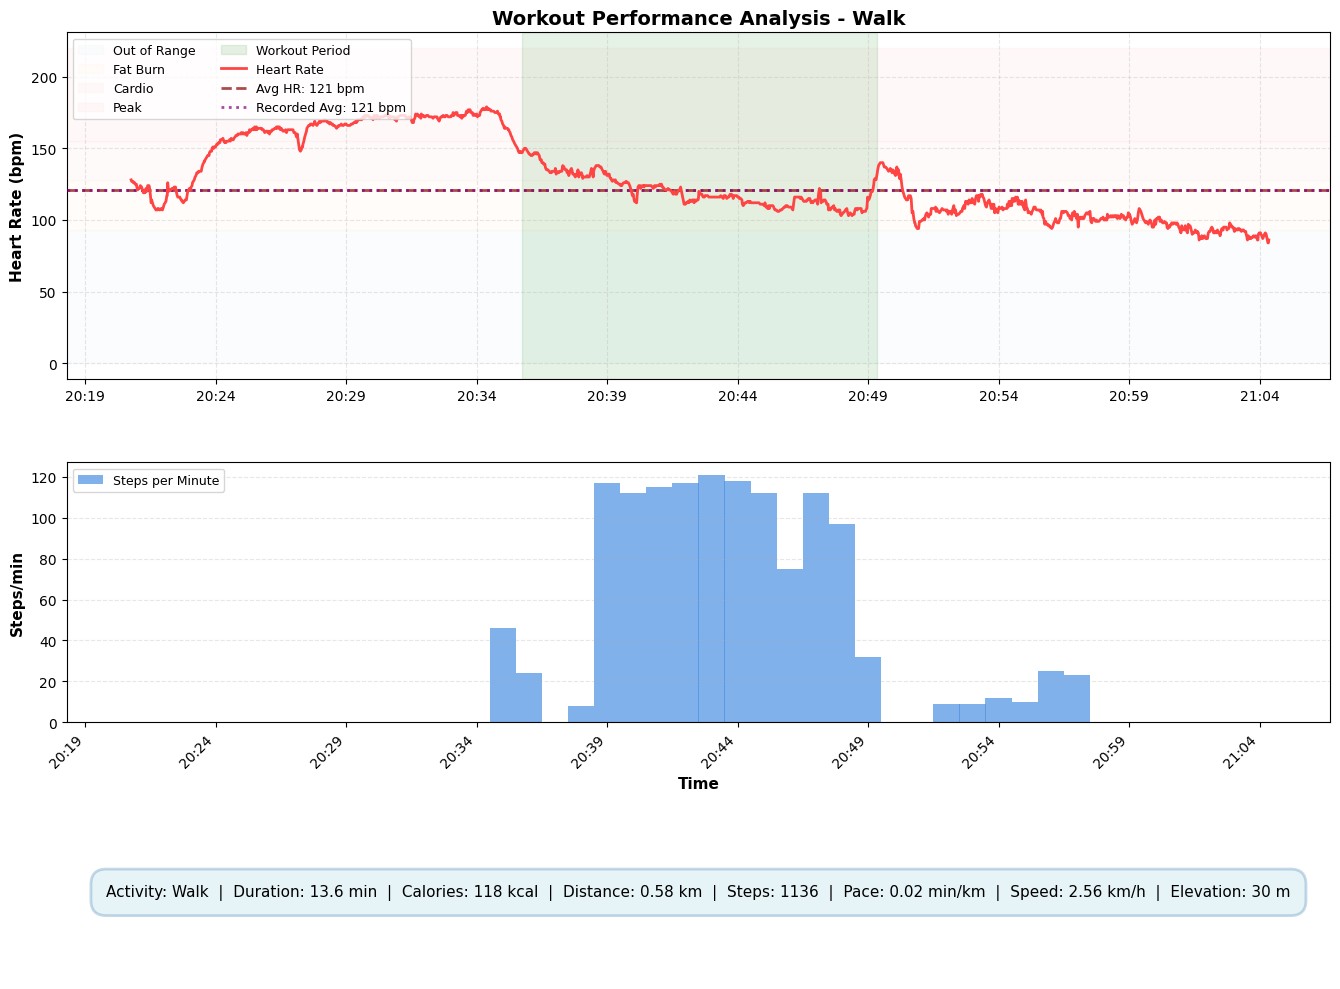

In [16]:
# CONFIGURE: Select which activity to analyze
# Change this to 0 for first activity, 1 for second, etc.
# The activity list is shown in the cell above
activity_index = 0

if ANALYSIS_MODE == 'single' and len(df_activity_records) > 0:
    try:
        selected_activity = df_activity_records.iloc[activity_index]
        
        print(f"Analyzing activity {activity_index}:")
        activity_name = selected_activity['ActivityName'] if 'ActivityName' in selected_activity else 'Unknown'
        print(f"  {activity_name} at {selected_activity['time']}\n")
        
        fig = plot_performance_timeline(
            df_hr_intra,
            df_steps_intra,
            selected_activity,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except IndexError:
        print(f"❌ Activity index {activity_index} not found.")
        print(f"   Available indices: 0 to {len(df_activity_records)-1}")
        print(f"   Please update 'activity_index' in the cell above")
    except Exception as e:
        print(f"❌ Error plotting: {e}")
elif ANALYSIS_MODE == 'single' and len(df_activity_records) == 0:
    print("❌ No activities to plot")
    print("   Try selecting a different date")
else:
    print("ℹ️  Single-day activity timeline - switch to ANALYSIS_MODE = 'single' to use")

---

## 5. Activity Performance Timeline 📈

Detailed view of a single activity showing:
- Heart rate throughout the activity
- Steps/pace progression
- HR zone distribution
- Performance metrics

**Configure:** Change `activity_index` above to select which activity to analyze (0 = first, 1 = second, etc.)

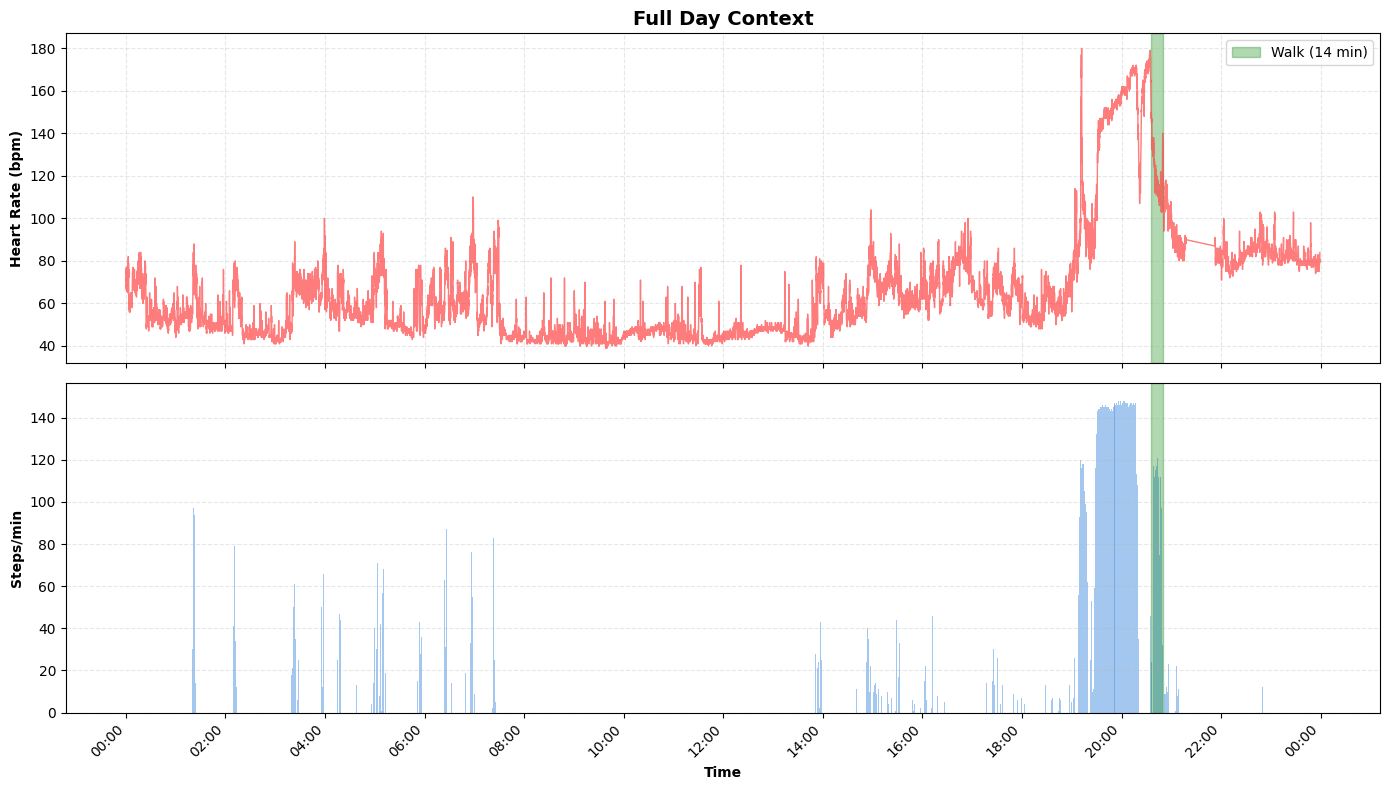

In [17]:
if ANALYSIS_MODE == 'single' and len(df_activity_records) > 0:
    try:
        # Reset index to ensure iloc works correctly
        df_activities_indexed = df_activity_records.reset_index(drop=True)
        
        fig = plot_full_day_with_workout_highlight(
            df_hr_intra,
            df_steps_intra,
            df_activities_indexed.iloc[activity_index],
            timezone='Europe/London'
        )
        plt.show()
    except IndexError:
        print(f"❌ Activity index {activity_index} not found.")
        print(f"   Available indices: 0 to {len(df_activity_records)-1}")
    except Exception as e:
        print(f"❌ Error plotting: {e}")
else:
    print("ℹ️  Full-day context view - switch to ANALYSIS_MODE = 'single' to use")

---

## 6. Full Day Context View 📅

Shows the selected activity in the context of your entire day:
- Full 24-hour heart rate timeline
- Activity period highlighted
- See how the workout affects resting HR
- Recovery patterns visible

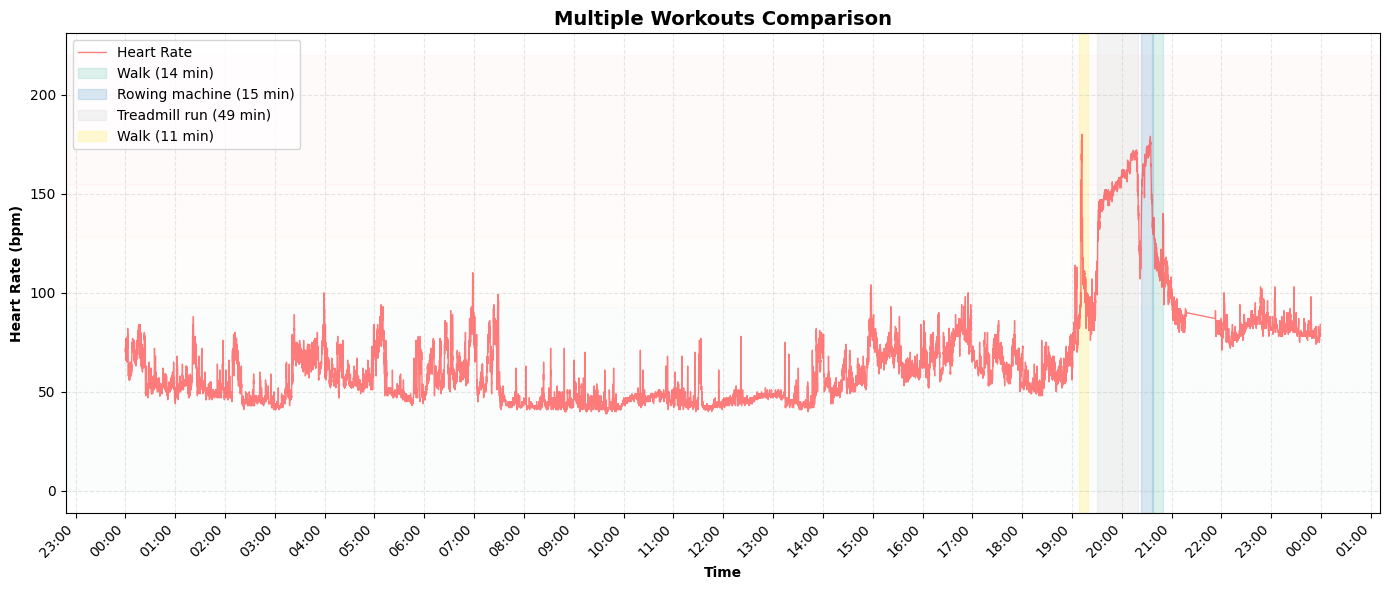

In [18]:
if ANALYSIS_MODE == 'single' and len(df_activity_records) > 1:
    try:
        fig = plot_multiple_workouts_comparison(
            df_hr_intra,
            df_steps_intra,
            df_activity_records,
            hr_zones=hr_zones,
            timezone='Europe/London'
        )
        plt.show()
    except Exception as e:
        print(f"❌ Error plotting: {e}")
elif ANALYSIS_MODE == 'single' and len(df_activity_records) <= 1:
    print("Only one activity found - comparison requires multiple workouts")
else:
    print("ℹ️  Multiple workouts comparison - switch to ANALYSIS_MODE = 'single' to use")

---

## 7. Multiple Activities Comparison 🔀

Side-by-side comparison when multiple activities exist on the same day:
- Compare heart rate patterns
- Compare intensity levels
- See how different activities affect your HR

In [19]:
if ANALYSIS_MODE == 'single' and len(df_activity_records) > 0:
    # Select relevant columns
    cols_to_show = [
        'time', 'ActivityName', 'calories', 'distance', 'steps',
        'speed', 'pace', 'averageHeartRate', 'duration',
        'elevationGain'
    ]
    
    # Filter columns that exist
    available_cols = [col for col in cols_to_show if col in df_activity_records.columns]
    
    print("\n📊 Activity Details:")
    print("="*100)
    display(df_activity_records[available_cols])
elif ANALYSIS_MODE == 'single':
    print("No activities found")
else:
    print("ℹ️  Single-day activity table - switch to ANALYSIS_MODE = 'single' to use")


📊 Activity Details:


,time,ActivityName,calories,distance,steps,speed,pace,averageHeartRate,duration,elevationGain
1246,2025-12-19 20:35:45.474000+00:00,Walk,118.0,0.581293,1136.0,2.564528,1403.767119,121.0,816000.0,30.0
1247,2025-12-19 20:22:43+00:00,Rowing machine,185.0,NaN,70.0,NaN,NaN,161.0,878000.0,0.0
1248,2025-12-19 19:30:14+00:00,Treadmill run,632.0,2.806212,7112.0,3.422210,1051.951884,154.0,2952000.0,0.0
1249,2025-12-19 19:08:19.950000+00:00,Walk,84.0,0.528228,1022.0,2.813681,1279.462656,107.0,675848.0,40.0


---

## 8. Activity Summary Table 📋

Quick overview of all activities with key metrics at a glance.

In [20]:
# Find ALL running/workout activities (GPS and non-GPS)
run_activity_names = ['Run', 'Jog', 'Structured Workout', 'Outdoor Run', 'Treadmill Run', 'Treadmill run', 'Sport']
run_activities = df_activity_records[
    df_activity_records['ActivityName'].isin(run_activity_names)
].copy()

if len(run_activities) > 0:
    print(f"Found {len(run_activities)} running/workout session(s)\n")
    
    for idx, run in run_activities.iterrows():
        print(f"{'='*80}")
        print(f"RUN ANALYSIS - {run['ActivityName']} - {run['time'].strftime('%Y-%m-%d %H:%M')}")
        print(f"{'='*80}\n")
        
        # Check if this has distance data
        if 'distance' not in run or pd.isna(run['distance']) or run['distance'] == 0:
            print("⚠️  No distance data available for this activity\n")
            continue
        
        # ===== CONVERT DISTANCE FROM MILES TO KILOMETERS =====
        # Fitbit API returns ALL activity distances in MILES
        MILES_TO_KM = 1.609344
        
        # Make a copy to avoid SettingWithCopyWarning
        run = run.copy()
        
        # Store original distance in miles and convert to km
        distance_miles = run['distance']
        distance_km = distance_miles * MILES_TO_KM
        
        # Update the run series with both values
        run['distance_miles'] = distance_miles
        run['distance'] = distance_km
        
        # Recalculate pace and speed with corrected distance
        if 'duration' in run and pd.notna(run['duration']):
            duration_seconds = run['duration'] / 1000
            run['pace'] = duration_seconds / distance_km  # seconds per km
            duration_hours = duration_seconds / 3600
            run['speed'] = distance_km / duration_hours  # km/h
        # ===== END CONVERSION =====
        
        # Basic metrics
        duration_sec = run['duration'] / 1000
        duration_min = duration_sec / 60
        
        # Check if this was originally in miles (has distance_miles field)
        if 'distance_miles' in run and pd.notna(run['distance_miles']):
            print(f"📏 Distance: {distance_km:.2f} km (converted from {run['distance_miles']:.2f} miles)")
        else:
            print(f"📏 Distance: {distance_km:.2f} km")
        
        print(f"⏱️  Duration: {int(duration_min)}:{int((duration_min % 1) * 60):02d} ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {run['calories']:.0f} kcal")
        
        if 'steps' in run and pd.notna(run['steps']):
            print(f"👣 Steps: {run['steps']:.0f}")
        
        if 'averageHeartRate' in run and pd.notna(run['averageHeartRate']):
            print(f"❤️  Average HR: {run['averageHeartRate']:.0f} bpm")
        
        # Pace and speed
        pace_per_km = run['pace']  # seconds per km (already recalculated)
        pace_min = int(pace_per_km // 60)
        pace_sec = int(pace_per_km % 60)
        speed_kmh = run['speed']  # Already recalculated
        
        print(f"\n⚡ Performance Metrics:")
        print(f"   Pace: {pace_min}:{pace_sec:02d} min/km ({pace_per_km:.0f} sec/km)")
        print(f"   Speed: {speed_kmh:.2f} km/h")
        
        # Cadence (steps per minute) - only if steps available
        if 'steps' in run and pd.notna(run['steps']) and run['steps'] > 0:
            cadence = (run['steps'] / duration_min)
            print(f"   Cadence: {cadence:.0f} steps/min")
        
        # Elevation
        if 'elevationGain' in run and pd.notna(run['elevationGain']):
            elevation_gain = run['elevationGain']
            print(f"   Elevation Gain: {elevation_gain:.0f} m")
        
        # Kilometer splits (estimated from average pace)
        if distance_km >= 1.0:
            print(f"\n📊 Estimated Kilometer Splits:")
            print(f"   (Based on average pace - actual splits may vary)")
            print(f"   {'KM':>3s} | {'Split Time':>12s} | {'Elapsed':>10s}")
            print(f"   {'-'*3:3s}-+-{'-'*12:12s}-+-{'-'*10:10s}")
            
            for km in range(1, int(distance_km) + 1):
                # Elapsed time at this km
                elapsed_sec = pace_per_km * km
                elapsed_min = int(elapsed_sec // 60)
                elapsed_sec_remainder = int(elapsed_sec % 60)
                
                # Split time (same as pace for constant speed)
                split_min = pace_min
                split_sec = pace_sec
                
                print(f"   {km:3d} | {split_min:2d}:{split_sec:02d} min/km | {elapsed_min:3d}:{elapsed_sec_remainder:02d}")
            
            # Final partial km if any
            remaining_distance = distance_km - int(distance_km)
            if remaining_distance >= 0.1:  # At least 100m
                elapsed_sec = duration_sec
                elapsed_min = int(elapsed_sec // 60)
                elapsed_sec_remainder = int(elapsed_sec % 60)
                
                partial_time_sec = remaining_distance * pace_per_km
                partial_min = int(partial_time_sec // 60)
                partial_sec = int(partial_time_sec % 60)
                
                print(f"  {remaining_distance:4.2f} | {partial_min:2d}:{partial_sec:02d}         | {elapsed_min:3d}:{elapsed_sec_remainder:02d}")
        
        # Efficiency metrics
        print(f"\n📊 Efficiency Metrics:")
        print(f"   Calories per km: {(run['calories'] / distance_km):.1f} kcal/km")
        
        if 'steps' in run and pd.notna(run['steps']) and run['steps'] > 0:
            print(f"   Steps per km: {(run['steps'] / distance_km):.0f} steps/km")
            print(f"   Meters per step: {(distance_km * 1000 / run['steps']):.2f} m/step")
        
        # Check for GPS data
        df_gps = dfs.get('GPS', pd.DataFrame())
        has_gps = False
        
        if not df_gps.empty:
            activity_id = f"{run['time'].isoformat()}-{run['ActivityName']}"
            run_gps = df_gps[df_gps['ActivityID'] == activity_id].copy()
            
            if not run_gps.empty:
                has_gps = True
                gps_distance_km = run_gps['distance'].max() / 1000
                print(f"\n🛰️  GPS Data:")
                print(f"   GPS trackpoints: {len(run_gps):,}")
                print(f"   GPS distance: {gps_distance_km:.2f} km")
                print(f"   API distance: {distance_km:.2f} km")
                diff_m = abs(gps_distance_km - distance_km) * 1000
                print(f"   Difference: {diff_m:.0f} meters")
                
                if diff_m < 50:
                    print(f"   ✅ Excellent GPS match!")
                elif diff_m < 100:
                    print(f"   ✅ Good GPS match")
        
        if not has_gps:
            print(f"\n📍 No GPS data (typical for treadmill runs)")
        
        # Heart rate analysis during the run (from intraday HR data)
        if not df_hr_intra.empty:
            from functions.performance_functions import extract_activity_time_window
            
            try:
                run_start, run_end, run_duration = extract_activity_time_window(run, 'Europe/London')
                
                # Get HR data during this run
                hr_during_run = df_hr_intra[
                    (df_hr_intra['time'] >= run_start) & 
                    (df_hr_intra['time'] <= run_end)
                ].copy()
                
                if not hr_during_run.empty and len(hr_during_run) > 0:
                    print(f"\n❤️  Heart Rate Analysis (from {len(hr_during_run):,} measurements):")
                    print(f"   Average: {hr_during_run['value'].mean():.0f} bpm")
                    print(f"   Min: {hr_during_run['value'].min():.0f} bpm")
                    print(f"   Max: {hr_during_run['value'].max():.0f} bpm")
                    print(f"   Median: {hr_during_run['value'].median():.0f} bpm")
                    
                    # HR zone distribution
                    print(f"\n   HR Zone Distribution:")
                    for zone_name, zone_info in hr_zones.items():
                        hr_in_zone = hr_during_run[
                            (hr_during_run['value'] >= zone_info['range'][0]) &
                            (hr_during_run['value'] < zone_info['range'][1])
                        ]
                        pct = (len(hr_in_zone) / len(hr_during_run)) * 100
                        if pct > 0:
                            time_in_zone_min = len(hr_in_zone) / 60  # ~1 second per measurement
                            print(f"     {zone_name:15s}: {pct:5.1f}% ({time_in_zone_min:5.1f} min)")
            except Exception as e:
                print(f"\n⚠️  Could not analyze HR data: {e}")
        
        print(f"\n")
else:
    print("No running/workout activities found for this date")
    print("\nActivities searched:")
    for name in run_activity_names:
        print(f"  - {name}")

Found 1 running/workout session(s)

RUN ANALYSIS - Treadmill run - 2025-12-19 19:30

📏 Distance: 4.52 km (converted from 2.81 miles)
⏱️  Duration: 49:12 (2952 seconds)
🔥 Calories: 632 kcal
👣 Steps: 7112
❤️  Average HR: 154 bpm

⚡ Performance Metrics:
   Pace: 10:53 min/km (654 sec/km)
   Speed: 5.51 km/h
   Cadence: 145 steps/min
   Elevation Gain: 0 m

📊 Estimated Kilometer Splits:
   (Based on average pace - actual splits may vary)
    KM |   Split Time |    Elapsed
   ----+--------------+-----------
     1 | 10:53 min/km |  10:53
     2 | 10:53 min/km |  21:47
     3 | 10:53 min/km |  32:40
     4 | 10:53 min/km |  43:34
  0.52 |  5:37         |  49:12

📊 Efficiency Metrics:
   Calories per km: 139.9 kcal/km
   Steps per km: 1575 steps/km
   Meters per step: 0.64 m/step

📍 No GPS data (typical for treadmill runs)

❤️  Heart Rate Analysis (from 1,345 measurements):
   Average: 154 bpm
   Min: 99 bpm
   Max: 172 bpm
   Median: 154 bpm

   HR Zone Distribution:
     Fat Burn       :   

---

## 9. Running & Workout Analysis 🏃‍♂️

Comprehensive running/workout analysis including:
- **Pace & Speed**: Per kilometer pace, average speed, cadence
- **Kilometer Splits**: Estimated splits based on average pace
- **Efficiency Metrics**: Calories/km, steps/km, stride length
- **Heart Rate Analysis**: Zone distribution during the run
- **GPS Validation**: Compare API distance vs GPS distance

Searches for activities: Run, Jog, Structured Workout, Treadmill Run, Sport

In [21]:
# Visualize pace variation and heart rate for GPS-tracked runs
df_gps = dfs.get('GPS', pd.DataFrame())

if len(run_activities) > 0 and not df_gps.empty:
    # Check what columns the GPS data has
    if 'ActivityID' not in df_gps.columns:
        print("⚠️  GPS data doesn't have ActivityID column")
        print(f"   Available columns: {list(df_gps.columns)}")
        print("\n   This cell requires GPS data with ActivityID to match activities.")
        print("   Skipping GPS visualization.\n")
    else:
        for idx, run in run_activities.iterrows():
            # Convert datetime to ISO format string to match GPS ActivityID format
            time_str = run['time'].isoformat()
            activity_id = f"{time_str}-{run['ActivityName']}"
            run_gps = df_gps[df_gps['ActivityID'] == activity_id].copy()
            
            if not run_gps.empty and 'heart_rate' in run_gps:
                print(f"Visualizing: {run['ActivityName']} - {run['time'].strftime('%Y-%m-%d %H:%M')}\n")
                
                run_gps = run_gps.sort_values('distance')
                run_gps['time'] = pd.to_datetime(run_gps['time'])
                
                # Calculate rolling pace (pace for each 100m segment)
                run_gps['distance_km'] = run_gps['distance'] / 1000
                
                # Create figure with 3 subplots
                fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12))
                
                # ================================================================
                # Plot 1: Heart Rate and Pace over Distance
                # ================================================================
                
                ax1_twin = ax1.twinx()
                
                # Plot heart rate
                ax1.plot(run_gps['distance_km'], run_gps['heart_rate'], 
                        color='#ff4444', linewidth=2, label='Heart Rate', alpha=0.8)
                ax1.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
                ax1.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold', color='#ff4444')
                ax1.tick_params(axis='y', labelcolor='#ff4444')
                ax1.grid(True, alpha=0.3)
                
                # Calculate rolling pace (using 200m windows)
                window_size = 40  # ~200m at 5m per point
                if len(run_gps) > window_size:
                    run_gps['time_diff'] = run_gps['time'].diff().dt.total_seconds()
                    run_gps['dist_diff'] = run_gps['distance'].diff()
                    run_gps['rolling_pace'] = (run_gps['time_diff'] / (run_gps['dist_diff'] / 1000))
                    
                    # Remove outliers (pace < 2 min/km or > 20 min/km)
                    run_gps.loc[(run_gps['rolling_pace'] < 120) | (run_gps['rolling_pace'] > 1200), 'rolling_pace'] = np.nan
                    
                    # Smooth the pace data
                    run_gps['rolling_pace_smooth'] = run_gps['rolling_pace'].rolling(window=window_size, center=True).mean()
                    
                    # Convert to min/km for display
                    run_gps['pace_min_km'] = run_gps['rolling_pace_smooth'] / 60
                    
                    ax1_twin.plot(run_gps['distance_km'], run_gps['pace_min_km'],
                                color='#4444ff', linewidth=2, label='Pace', alpha=0.6)
                    ax1_twin.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold', color='#4444ff')
                    ax1_twin.tick_params(axis='y', labelcolor='#4444ff')
                    ax1_twin.invert_yaxis()  # Faster pace at top
                
                ax1.set_title(f'{run["ActivityName"]} - Heart Rate & Pace Profile', 
                             fontsize=14, fontweight='bold')
                
                # ================================================================
                # Plot 2: Elevation Profile
                # ================================================================
                
                if 'altitude' in run_gps:
                    ax2.fill_between(run_gps['distance_km'], run_gps['altitude'], 
                                    alpha=0.3, color='#8B4513')
                    ax2.plot(run_gps['distance_km'], run_gps['altitude'], 
                            color='#8B4513', linewidth=2, label='Elevation')
                    ax2.set_xlabel('Distance (km)', fontsize=12, fontweight='bold')
                    ax2.set_ylabel('Elevation (m)', fontsize=12, fontweight='bold')
                    ax2.set_title('Elevation Profile', fontsize=14, fontweight='bold')
                    ax2.grid(True, alpha=0.3)
                    
                    # Add stats
                    elev_gain = run.get('elevationGain', 0)
                    elev_range = run_gps['altitude'].max() - run_gps['altitude'].min()
                    ax2.text(0.02, 0.98, f'Gain: {elev_gain:.0f}m | Range: {elev_range:.0f}m',
                            transform=ax2.transAxes, va='top', fontsize=10,
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                # ================================================================
                # Plot 3: Kilometer Splits Bar Chart
                # ================================================================
                
                distance_km = run['distance']
                splits_data = []
                
                for km in range(1, int(distance_km) + 1):
                    km_distance_m = km * 1000
                    closest_idx = (run_gps['distance'] - km_distance_m).abs().idxmin()
                    km_point = run_gps.loc[closest_idx]
                    
                    if km == 1:
                        prev_point = run_gps.iloc[0]
                    else:
                        prev_km_m = (km - 1) * 1000
                        prev_idx = (run_gps['distance'] - prev_km_m).abs().idxmin()
                        prev_point = run_gps.loc[prev_idx]
                    
                    split_seconds = (km_point['time'] - prev_point['time']).total_seconds()
                    km_actual_distance = (km_point['distance'] - prev_point['distance']) / 1000
                    
                    if km_actual_distance > 0:
                        split_pace = split_seconds / km_actual_distance
                        splits_data.append({'km': km, 'pace': split_pace})
                
                if splits_data:
                    splits_df = pd.DataFrame(splits_data)
                    
                    # Color bars by pace (faster = green, slower = red)
                    avg_pace = splits_df['pace'].mean()
                    colors = ['#00aa00' if p <= avg_pace else '#aa0000' for p in splits_df['pace']]
                    
                    bars = ax3.bar(splits_df['km'], splits_df['pace'] / 60, color=colors, 
                                  edgecolor='black', linewidth=1.5, alpha=0.7)
                    
                    # Add pace labels on bars
                    for bar, pace in zip(bars, splits_df['pace']):
                        height = bar.get_height()
                        pace_min = int(pace // 60)
                        pace_sec = int(pace % 60)
                        ax3.text(bar.get_x() + bar.get_width()/2., height,
                               f'{pace_min}:{pace_sec:02d}',
                               ha='center', va='bottom', fontsize=9, fontweight='bold')
                    
                    # Add average pace line
                    ax3.axhline(avg_pace / 60, color='blue', linestyle='--', linewidth=2, 
                               label=f'Avg: {int(avg_pace//60)}:{int(avg_pace%60):02d}', alpha=0.7)
                    
                    ax3.set_xlabel('Kilometer', fontsize=12, fontweight='bold')
                    ax3.set_ylabel('Pace (min/km)', fontsize=12, fontweight='bold')
                    ax3.set_title('Kilometer Splits (Green = faster than avg, Red = slower)', 
                                 fontsize=14, fontweight='bold')
                    ax3.set_xticks(splits_df['km'])
                    ax3.legend()
                    ax3.grid(True, alpha=0.3, axis='y')
                
                plt.tight_layout()
                plt.show()
                
                print("\n" + "="*80)
else:
    if len(run_activities) == 0:
        print("No running activities found to visualize")
    elif df_gps.empty:
        print("No GPS data available (typical for treadmill runs)")

No GPS data available (typical for treadmill runs)


---

## 10. GPS Track Visualization 🗺️

For GPS-tracked runs, visualize:
- **Heart rate & pace** progression over distance
- **Elevation profile** showing climbs and descents
- **Kilometer splits** with color coding (green = faster, red = slower)

*Note: Treadmill runs typically don't have reliable GPS data*

## 10. Swim-Specific Analysis

Detailed analysis for swimming sessions including pace per 100m, GPS data, and heart rate during swim

**⚠️ Known Issue:** Fitbit API returns swim distances in **miles** (not km like other activities). This notebook converts them correctly, but `fitbit2s3.py` should be updated to handle this at the data collection stage for future consistency.

In [22]:
# Configuration
POOL_LENGTH = 25  # meters
MILES_TO_KM = 1.609344  # Conversion factor

# Find all swim activities
swim_activities = df_activity_records[df_activity_records['ActivityName'] == 'Swim'].copy()

if len(swim_activities) > 0:
    print(f"Found {len(swim_activities)} swim session(s)\n")
    
    for idx, swim in swim_activities.iterrows():
        print(f"{'='*80}")
        print(f"SWIM SESSION ANALYSIS - {swim['time']}")
        print(f"{'='*80}\n")
        
        # FIX: Fitbit API returns swim distances in MILES, not kilometers!
        # Convert to meters correctly
        distance_from_api = swim['distance']  # This is in MILES for swimming
        distance_m = distance_from_api * MILES_TO_KM * 1000  # Convert miles -> km -> meters
        distance_km = distance_m / 1000
        
        print(f"⚠️ Note: Fitbit returns swim distance in miles ({distance_from_api:.3f} mi)")
        print(f"📏 Distance: {distance_m:.0f} meters ({distance_km:.2f} km)")
        
        # Duration
        duration_min = swim['duration'] / 1000 / 60
        duration_sec = swim['duration'] / 1000
        
        print(f"⏱️ Duration: {duration_min:.1f} minutes ({duration_sec:.0f} seconds)")
        print(f"🔥 Calories: {swim['calories']:.0f} kcal")
        
        # Recalculate speed with correct distance
        speed_kmh = (distance_km / duration_sec) * 3600
        print(f"⚡ Speed: {speed_kmh:.2f} km/h\n")
        
        # Calculate pace per 100m with CORRECT distance
        pace_sec_per_100m = duration_sec / (distance_m / 100)
        pace_min = int(pace_sec_per_100m // 60)
        pace_sec = int(pace_sec_per_100m % 60)
        
        print(f"🏊 Pace per 100m: {pace_min}:{pace_sec:02d} min/100m")
        
        # Laps in 25m pool
        laps = distance_m / POOL_LENGTH
        complete_laps = int(laps)
        
        print(f"\n🔄 Laps ({POOL_LENGTH}m pool): {laps:.1f} laps ({complete_laps} complete laps)")
        
        # Length breakdown
        complete_lengths = int(distance_m / POOL_LENGTH)
        remaining_meters = distance_m % POOL_LENGTH
        print(f"   = {complete_lengths} lengths", end='')
        if remaining_meters >= 1:
            print(f" + {remaining_meters:.0f}m")
        else:
            print()
        
        # Average time per lap
        if complete_laps > 0:
            sec_per_lap = duration_sec / laps
            lap_min = int(sec_per_lap // 60)
            lap_sec = int(sec_per_lap % 60)
            print(f"   Average time per lap: {lap_min}:{lap_sec:02d}")
        
        print(f"\n📊 Additional Metrics:")
        print(f"   Calories per 100m: {(swim['calories'] / (distance_m / 100)):.1f} kcal")
        print(f"   Meters per minute: {distance_m / duration_min:.1f} m/min")
        
        print(f"\n")
else:
    print("No swim activities found for this date")

No swim activities found for this date


---

## 11. Swimming Analysis 🏊‍♂️

Specialized metrics for pool swimming:
- **Pace per 100m**: Swimming-specific pace calculation
- **Lap counting**: Total laps and lengths in pool
- **Pool metrics**: Based on 25m pool length (configurable)
- **Efficiency**: Calories per 100m, meters per minute

**⚠️ Note:** Fitbit returns swim distances in miles - this is corrected automatically

In [23]:
# Debug: Check what activity types are available in the data
print("="*80)
print("ACTIVITY TYPES IN DATA")
print("="*80)

if not df_activity_records.empty:
    activity_types = df_activity_records['ActivityName'].value_counts()
    
    print(f"\nFound {len(activity_types)} different activity types:")
    print(f"\n{'Activity Type':30s} | Count")
    print("-" * 45)
    for activity_type, count in activity_types.items():
        print(f"{activity_type:30s} | {count:5d}")
    
    # Check for swimming activities
    swim_activities = df_activity_records[
        df_activity_records['ActivityName'].str.contains('Swim', case=False, na=False)
    ]
    
    if not swim_activities.empty:
        print(f"\n✅ Found {len(swim_activities)} swim activity/activities!")
        for idx, swim in swim_activities.iterrows():
            print(f"   - {swim['ActivityName']} on {swim['time']}")
    else:
        print(f"\n⚠️  No swim activities found in the current date ({TARGET_DATE})")
        print(f"   Try selecting a different date that includes swimming")
else:
    print("\n⚠️  No activity records found")
    print(f"   Check that target_date ({target_date}) has activity data")

ACTIVITY TYPES IN DATA

Found 3 different activity types:

Activity Type                  | Count
---------------------------------------------
Walk                           |     2
Rowing machine                 |     1
Treadmill run                  |     1

⚠️  No swim activities found in the current date (2025-12-19)
   Try selecting a different date that includes swimming


---

## 🔧 Debug & Troubleshooting

**Optional:** Use this section to verify what activity types are available in your data. Helpful when:
- Expected activities aren't showing up
- Checking activity name variations (e.g., "Run" vs "Outdoor Run")
- Verifying data was loaded correctly

In [24]:
# Check for GPS data
df_gps = dfs.get('GPS', pd.DataFrame())

if not df_gps.empty:
    print(f"✅ Found {len(df_gps)} GPS trackpoints\n")
    print(df_gps.head(10))
else:
    print("⚠️  No GPS data found (expected for pool swimming)\n")

# Check if there's heart rate data during swim sessions
if len(swim_activities) > 0 and not df_hr_intra.empty:
    print(f"\n{'='*80}")
    print("HEART RATE DURING SWIM")
    print(f"{'='*80}\n")
    
    for idx, swim in swim_activities.iterrows():
        # Extract activity time window
        from functions.performance_functions import extract_activity_time_window
        swim_start, swim_end, duration = extract_activity_time_window(swim, 'Europe/London')
        
        # Filter HR data to swim window
        hr_during_swim = df_hr_intra[
            (df_hr_intra['time'] >= swim_start) & 
            (df_hr_intra['time'] <= swim_end)
        ].copy()
        
        if not hr_during_swim.empty:
            print(f"Swim at {swim['time']}:")
            print(f"  ✅ Found {len(hr_during_swim)} heart rate measurements during swim")
            print(f"  📊 HR Statistics:")
            print(f"     - Average: {hr_during_swim['value'].mean():.1f} bpm")
            print(f"     - Min: {hr_during_swim['value'].min():.0f} bpm")
            print(f"     - Max: {hr_during_swim['value'].max():.0f} bpm")
            print(f"     - Median: {hr_during_swim['value'].median():.1f} bpm\n")
            
            # Show HR distribution
            print(f"  HR Zone Distribution:")
            for zone_name, zone_info in hr_zones.items():
                hr_in_zone = hr_during_swim[
                    (hr_during_swim['value'] >= zone_info['range'][0]) &
                    (hr_during_swim['value'] < zone_info['range'][1])
                ]
                pct = (len(hr_in_zone) / len(hr_during_swim)) * 100
                print(f"     - {zone_name:15s}: {pct:5.1f}% ({len(hr_in_zone):4d} measurements)")
        else:
            print(f"  ⚠️  No heart rate data found during swim (watch may not track HR in water)\n")

⚠️  No GPS data found (expected for pool swimming)



---

## 12. Swimming Heart Rate Analysis 💓

Analyze heart rate during swimming sessions:
- Check if watch tracked HR in water
- Zone distribution during swim
- Average, min, max HR during swim

*Note: Some watches may not track HR underwater*

HEART RATE TIMELINE WITH ACTIVITIES



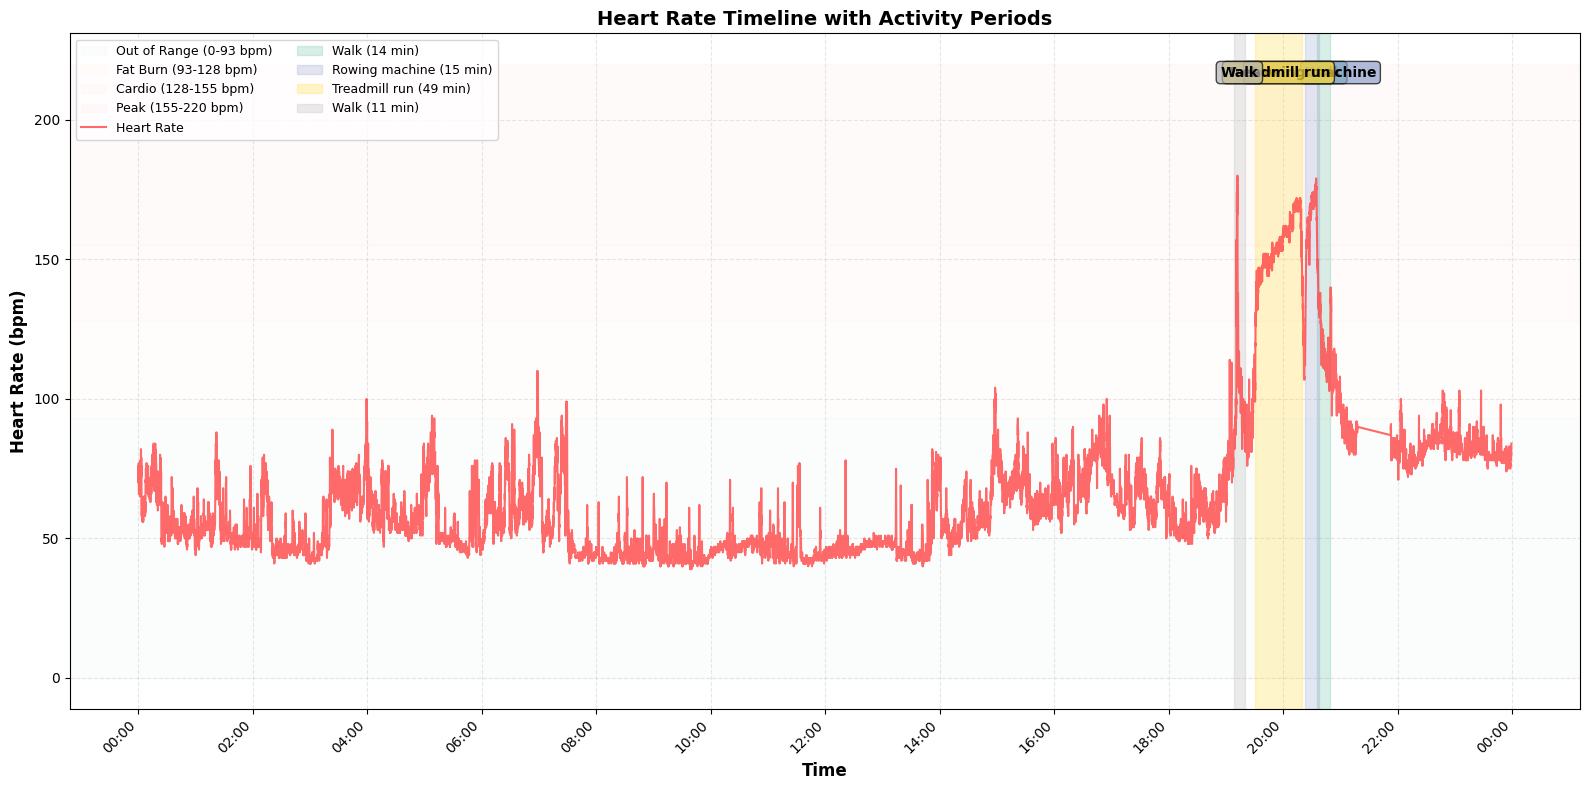


Timeline shows:
  - Colored bands: Heart rate zones
  - Red line: Your actual heart rate throughout the day
  - Highlighted regions: Activity periods
  - You can see how activities affect your HR and which zones you reached


In [25]:
# Timeline view: HR zones with activities highlighted
if ANALYSIS_MODE == 'single' and not df_hr_intra.empty and len(df_activity_records) > 0:
    print("="*80)
    print("HEART RATE TIMELINE WITH ACTIVITIES")
    print("="*80 + "\n")
    
    from functions.performance_functions import convert_timezone_safe, extract_activity_time_window
    
    # Convert HR data to local timezone for plotting
    df_hr_plot = convert_timezone_safe(df_hr_intra.copy(), target_tz='Europe/London')
    
    # Create figure
    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Plot HR zones as background bands
    for zone_name, zone_info in hr_zones.items():
        ax.axhspan(zone_info['range'][0], zone_info['range'][1], 
                  alpha=0.15, color=zone_info['color'], 
                  label=f"{zone_name} ({zone_info['range'][0]}-{zone_info['range'][1]} bpm)")
    
    # Plot heart rate line
    ax.plot(df_hr_plot['time'], df_hr_plot['value'], 
           color='#ff4444', linewidth=1.5, alpha=0.8, label='Heart Rate', zorder=5)
    
    # Highlight activity periods
    activity_colors = plt.cm.Set2(np.linspace(0, 1, len(df_activity_records)))
    
    for idx, (activity_idx, activity) in enumerate(df_activity_records.iterrows()):
        activity_start, activity_end, duration = extract_activity_time_window(activity, 'Europe/London')
        
        # Add vertical span for activity
        ax.axvspan(activity_start, activity_end, 
                  alpha=0.25, color=activity_colors[idx], 
                  label=f"{activity['ActivityName']} ({duration:.0f} min)", zorder=2)
        
        # Add text label at the top
        mid_time = activity_start + (activity_end - activity_start) / 2
        ax.text(mid_time, ax.get_ylim()[1] * 0.95, 
               activity['ActivityName'], 
               ha='center', va='top', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor=activity_colors[idx], alpha=0.7))
    
    # Customize plot
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Heart Rate (bpm)', fontsize=12, fontweight='bold')
    ax.set_title('Heart Rate Timeline with Activity Periods', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis
    import matplotlib.dates as mdates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz='Europe/London'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Legend
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTimeline shows:")
    print("  - Colored bands: Heart rate zones")
    print("  - Red line: Your actual heart rate throughout the day")
    print("  - Highlighted regions: Activity periods")
    print("  - You can see how activities affect your HR and which zones you reached")
    
else:
    if ANALYSIS_MODE != 'single':
        print("ℹ️  Daily HR timeline - switch to ANALYSIS_MODE = 'single' to use")
    else:
        print("Need both heart rate data and activity records for timeline view")

---

## 13. Daily Heart Rate Timeline 🕐

Full day visualization showing:
- Heart rate zones as colored bands
- Your actual HR throughout the day
- All activities highlighted with colored regions
- See how activities spike your HR and recovery patterns

ACTIVITY LEVEL DISTRIBUTION



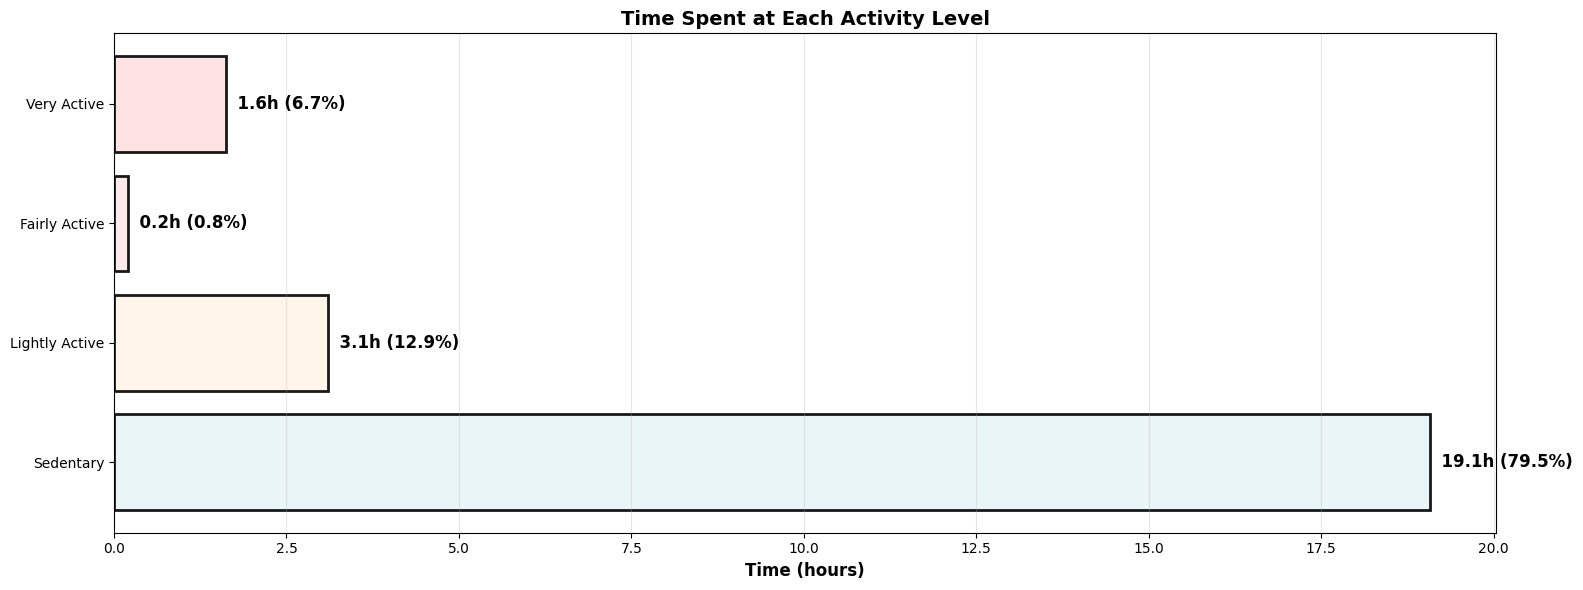

In [26]:
# Extract activity level data
if ANALYSIS_MODE == 'single':
    activity_levels = {
        'Sedentary': dfs.get('Activity-minutesSedentary', pd.DataFrame()),
        'Lightly Active': dfs.get('Activity-minutesLightlyActive', pd.DataFrame()),
        'Fairly Active': dfs.get('Activity-minutesFairlyActive', pd.DataFrame()),
        'Very Active': dfs.get('Activity-minutesVeryActive', pd.DataFrame())
    }
    # Check if we have activity level data
    has_data = any(not df.empty for df in activity_levels.values())
    if has_data:
        print("="*80)
        print("ACTIVITY LEVEL DISTRIBUTION")
        print("="*80 + "\n")
        
        # Collect data
        level_data = []
        total_minutes = 0
        
        # Define colors for activity levels
        level_colors = {
            'Sedentary': '#E8F4F8',
            'Lightly Active': '#FFF4E6',
            'Fairly Active': '#FFE8E8',
            'Very Active': '#FFE0E0'
        }
        
        for level_name, df in activity_levels.items():
            if not df.empty:
                minutes = df.iloc[0]['value']
                hours = minutes / 60
                total_minutes += minutes
                
                level_data.append({
                    'level': level_name,
                    'minutes': minutes,
                    'hours': hours,
                    'color': level_colors[level_name]
                })
        
        # Calculate percentages
        for item in level_data:
            item['percentage'] = (item['minutes'] / total_minutes) * 100 if total_minutes > 0 else 0
        
        # Create visualizations
        fig, ax = plt.subplots(figsize=(16, 6))
        
        levels = [item['level'] for item in level_data]
        hours = [item['hours'] for item in level_data]
        colors = [item['color'] for item in level_data]
        
        bars = ax.barh(levels, hours, color=colors, edgecolor='black', linewidth=2, alpha=0.9)
        
        # Add value labels
        for bar, item in zip(bars, level_data):
            width = bar.get_width()
            label = f"{item['hours']:.1f}h ({item['percentage']:.1f}%)"
            ax.text(width, bar.get_y() + bar.get_height()/2, 
                    f'  {label}', 
                    va='center', fontsize=12, fontweight='bold')
        
        ax.set_xlabel('Time (hours)', fontsize=12, fontweight='bold')
        ax.set_title('Time Spent at Each Activity Level', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No activity level data available")
else:
    print("ℹ️  Activity level distribution - switch to ANALYSIS_MODE = 'single' to use")

---

## 14. Activity Level Distribution 🎯

Fitbit categorizes your day into four activity levels:
- **Sedentary**: Sitting, lying down, minimal movement
- **Lightly Active**: Casual walking, light household tasks
- **Fairly Active**: Brisk walking, active chores
- **Very Active**: Running, intense exercise, sports

Shows how you spend your 24 hours.

In [27]:
if ANALYSIS_MODE == 'single' and not df_hr_intra.empty:
    print(f"Analyzing {len(df_hr_intra):,} heart rate measurements\n")
    
    # Calculate time in each zone
    zone_data = []
    zone_colors = []
    
    for zone_name, zone_info in hr_zones.items():
        hr_in_zone = df_hr_intra[
            (df_hr_intra['value'] >= zone_info['range'][0]) &
            (df_hr_intra['value'] < zone_info['range'][1])
        ]
        
        # Each measurement is ~1 second apart for HR data
        minutes_in_zone = len(hr_in_zone) / 60
        hours_in_zone = minutes_in_zone / 60
        percentage = (len(hr_in_zone) / len(df_hr_intra)) * 100
        
        zone_data.append({
            'zone': zone_name,
            'count': len(hr_in_zone),
            'minutes': minutes_in_zone,
            'hours': hours_in_zone,
            'percentage': percentage,
            'color': zone_info['color'],
            'range': f"{zone_info['range'][0]}-{zone_info['range'][1]} bpm"
        })
        zone_colors.append(zone_info['color'])
else:
    if ANALYSIS_MODE != 'single':
        print("ℹ️  HR zone distribution - switch to ANALYSIS_MODE = 'single' to use")
    else:
        print("No heart rate data available")

Analyzing 38,776 heart rate measurements



---

## 15. Heart Rate Zone Distribution ❤️‍🔥

Calculate time spent in each heart rate zone throughout the day:
- Each HR measurement is ~1 second apart
- Total time and percentage in each zone
- Helps understand daily cardiovascular load

In [28]:
# Combined view: Activity Levels vs HR Zones
if ANALYSIS_MODE == 'single' and has_data and 'zone_data' in globals():
    print("\n" + "="*80)
    print("ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON")
    print("="*80 + "\n")
    
    # Analysis
    print("\nKey Insights:")
    print("-" * 60)
    
    # Calculate active time
    active_time = sum(item['hours'] for item in level_data 
                     if item['level'] != 'Sedentary')
    sedentary_time = next((item['hours'] for item in level_data 
                          if item['level'] == 'Sedentary'), 0)
    
    print(f"\n📊 Activity Summary:")
    print(f"   Total Active Time: {active_time:.1f} hours ({(active_time/24)*100:.1f}% of day)")
    print(f"   Sedentary Time: {sedentary_time:.1f} hours ({(sedentary_time/24)*100:.1f}% of day)")
    
    # Calculate total HR hours and elevated HR time
    total_hr_hours = sum(z['hours'] for z in zone_data)
    elevated_hr_zones = ['Fat Burn', 'Cardio', 'Peak']
    elevated_hr_time = sum(z['hours'] for z in zone_data 
                          if z['zone'] in elevated_hr_zones)
    
    print(f"\n❤️  Heart Rate Summary:")
    print(f"   Elevated HR Time (Fat Burn+): {elevated_hr_time:.1f} hours")
    print(f"   Percentage of tracked HR: {(elevated_hr_time/total_hr_hours)*100:.1f}%")
    
    # Activity goal check (WHO recommends 150 min moderate activity/week)
    fairly_very_active = sum(item['minutes'] for item in level_data 
                            if item['level'] in ['Fairly Active', 'Very Active'])
    daily_target = 150 / 7  # ~21.4 minutes per day
    
    print(f"\n🎯 Activity Goal (WHO Guidelines):")
    print(f"   Fairly/Very Active: {fairly_very_active:.0f} minutes")
    print(f"   Daily target: ~{daily_target:.0f} minutes")
    if fairly_very_active >= daily_target:
        print(f"   ✅ Goal achieved! ({(fairly_very_active/daily_target)*100:.0f}% of target)")
    else:
        shortfall = daily_target - fairly_very_active
        print(f"   ⚠️  {shortfall:.0f} minutes short of daily target")

elif ANALYSIS_MODE != 'single':
    print("ℹ️  Activity vs HR comparison - switch to ANALYSIS_MODE = 'single' to use")
else:
    print("Need both activity level and HR zone data for comparison")


ACTIVITY LEVELS vs. HEART RATE ZONES COMPARISON


Key Insights:
------------------------------------------------------------

📊 Activity Summary:
   Total Active Time: 4.9 hours (20.5% of day)
   Sedentary Time: 19.1 hours (79.5% of day)

❤️  Heart Rate Summary:
   Elevated HR Time (Fat Burn+): 0.9 hours
   Percentage of tracked HR: 8.4%

🎯 Activity Goal (WHO Guidelines):
   Fairly/Very Active: 109 minutes
   Daily target: ~21 minutes
   ✅ Goal achieved! (509% of target)


---

## 16. Activity vs Heart Rate Summary 📊

Compare your movement levels with cardiovascular activity:
- **Activity levels** (Fitbit's motion-based classification)
- **Heart rate zones** (actual cardiovascular effort)
- **WHO Guidelines**: 150 minutes moderate activity per week (~21 min/day)
- See if your active time correlates with elevated heart rate